In [1]:
import pandas as pd
df = pd.read_csv('C:/Users/Desktop/Project/dataset.csv')

#df.fillna(df.mean(), inplace=True)
df.fillna(df.mean(numeric_only=True), inplace=True)

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Desktop/Project/dataset.csv'

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#AIC

In [7]:
from statsmodels.tsa.arima.model import ARIMA
import itertools

countries_to_keep = ['India', 'Madagascar', 'Canada', 'Iceland', 'Australia', 'Japan']
df = df[df['Location'].isin(countries_to_keep)]

df_train = df[(df['Time'] >= 2003) & (df['Time'] <= 2020)]
df_test = df[(df['Time'] >= 2020) & (df['Time'] <= 2022)]
df_predict = df[(df['Time'] >= 2022) & (df['Time'] <= 2032)]

population_column = 'TPopulation1Jan'

predictions_df = pd.DataFrame(columns=['Location', 'Year', 'Population_Prediction_ARIMA'])

def find_best_params(country, population_column, df_train):
    country_train_data = df_train[df_train['Location'] == country]
    population_series = country_train_data[population_column]

    
    p = d = q = range(0, 3)
    pdq = list(itertools.product(p, d, q))

    best_aic = float('inf')
    best_params = None

    for params in pdq:
        try:
            model = ARIMA(population_series, order=params)
            results = model.fit()

            if results.aic < best_aic:
                best_aic = results.aic
                best_params = params

        except Exception as e:
            continue

    return best_params, best_aic


best_params_dict = {}

for country in countries_to_keep:
    best_params, best_aic = find_best_params(country, 'TPopulation1Jan', df_train)
    best_params_dict[country] = {'best_params': best_params, 'best_aic': best_aic}

for country, params in best_params_dict.items():
    print(f'Best ARIMA parameters for {country}: {params["best_params"]} - AIC: {params["best_aic"]}')


Best ARIMA parameters for India: (1, 2, 1) - AIC: 240.6885933754921
Best ARIMA parameters for Madagascar: (1, 2, 0) - AIC: 109.77639671140199
Best ARIMA parameters for Canada: (0, 2, 1) - AIC: 158.6488335651291
Best ARIMA parameters for Iceland: (0, 2, 0) - AIC: 76.76367199325355
Best ARIMA parameters for Australia: (0, 2, 1) - AIC: 154.55224159372727
Best ARIMA parameters for Japan: (1, 2, 1) - AIC: 164.65155829774918


In [ ]:
#Forecasting


India - Train Data:
Train Actual Values:
16165    1107939.870
16166    1126890.377
16167    1145638.789
16168    1163638.637
16169    1181108.939
16170    1198274.680
16171    1215194.931
16172    1232085.388
16173    1249141.852
16174    1266100.530
16175    1282873.899
16176    1299390.228
16177    1315102.790
16178    1330630.219
16179    1346642.460
16180    1361748.899
16181    1376257.714
16182    1389966.387
Name: TPopulation1Jan, dtype: float64
Train Predicted Values:
16165    0.000000e+00
16166    1.697889e+06
16167    1.145513e+06
16168    1.164060e+06
16169    1.181310e+06
16170    1.198250e+06
16171    1.215112e+06
16172    1.231787e+06
16173    1.248649e+06
16174    1.265873e+06
16175    1.282735e+06
16176    1.299323e+06
16177    1.315583e+06
16178    1.330490e+06
16179    1.345833e+06
16180    1.362333e+06
16181    1.376532e+06
16182    1.390442e+06
dtype: float64
India: R^2 = -1.5707, MSE = 215665929.9643

India - Test Data:
Test Actual Values:
16182    1389966.387
161

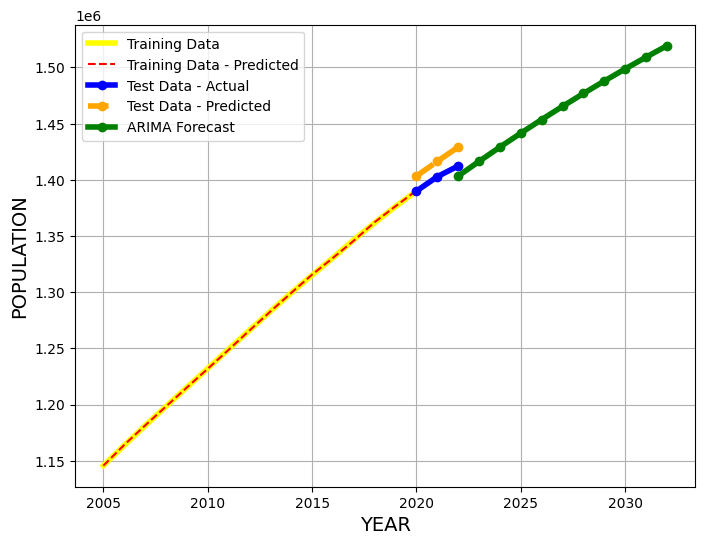

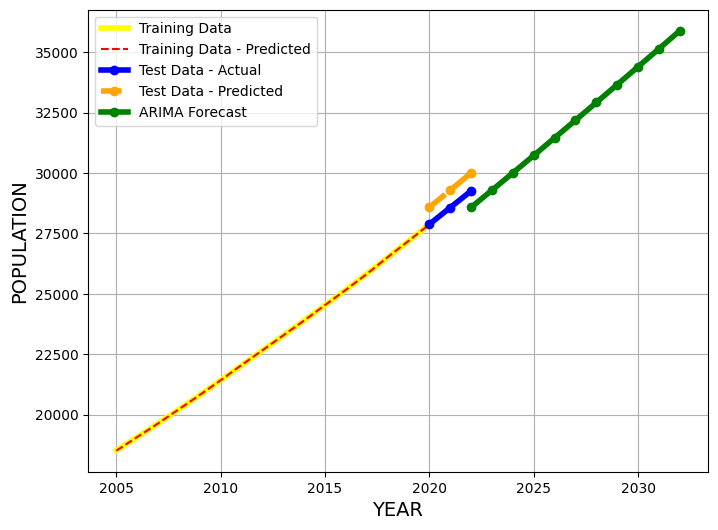

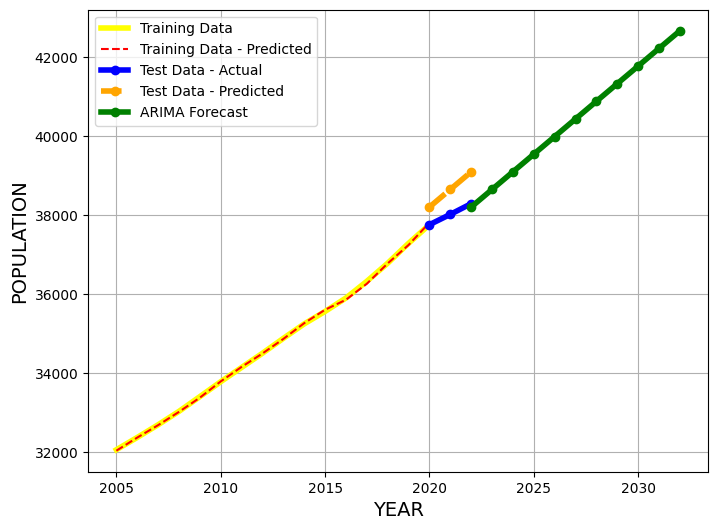

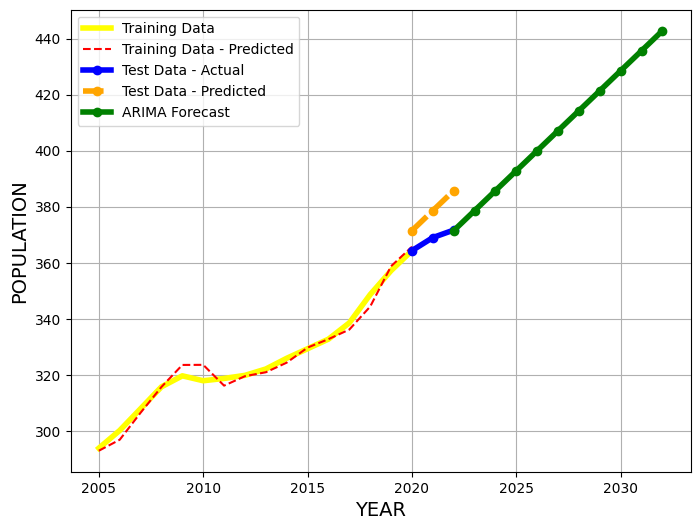

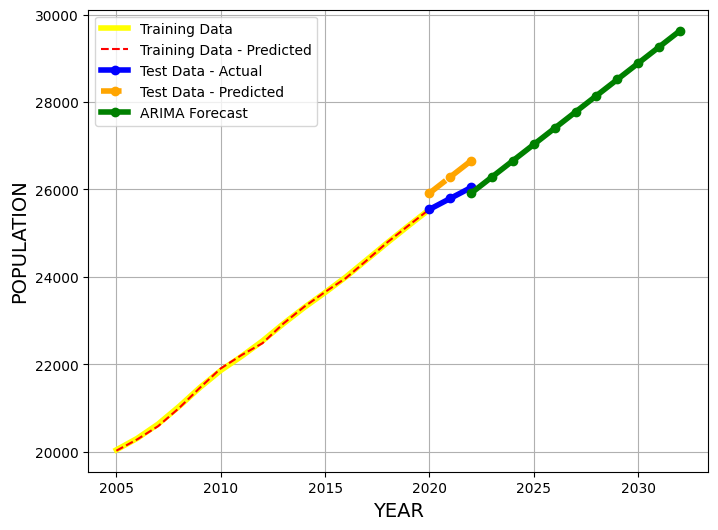

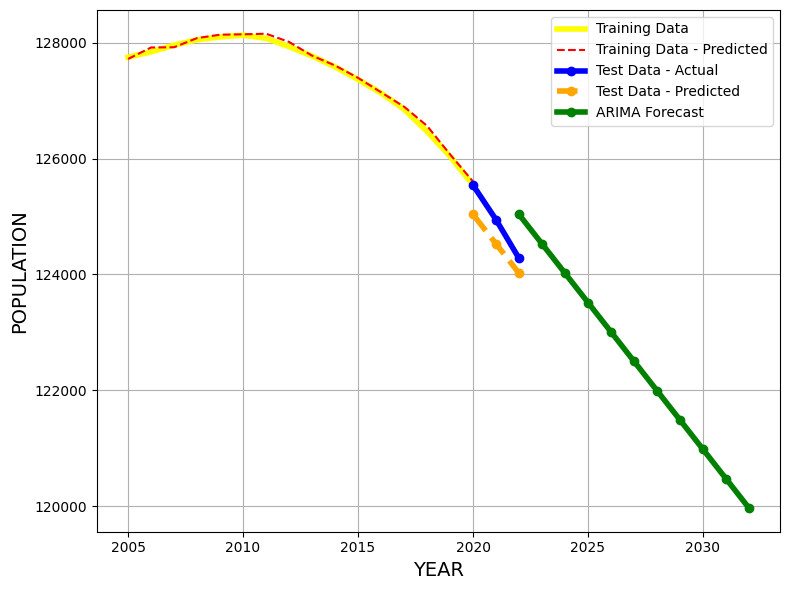

   Location  Year  Population_Prediction_ARIMA
0     India  2022                 1.403350e+06
1     India  2023                 1.416408e+06
2     India  2024                 1.429140e+06
3     India  2025                 1.441548e+06
4     India  2026                 1.453631e+06
..      ...   ...                          ...
61    Japan  2028                 1.219938e+05
62    Japan  2029                 1.214868e+05
63    Japan  2030                 1.209798e+05
64    Japan  2031                 1.204729e+05
65    Japan  2032                 1.199659e+05

[66 rows x 3 columns]
Average R^2: -4.333972528707054
Average MSE: 36170228.66109935


In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

r2_scores = []
mse_scores = []

for i, country in enumerate(countries_to_keep):
    fig, ax = plt.subplots(figsize=(8, 6))
    country_train_data = df_train[df_train['Location'] == country]
    country_test_data = df_test[df_test['Location'] == country]
    country_predict_data = df_predict[df_predict['Location'] == country]

    y_train = country_train_data[population_column]
    
    if country == 'Japan':
        order = (0, 2, 1)
    elif country == 'Australia':
        order = (0, 2, 1)
    elif country == 'Iceland':
        order = (0, 2, 0)
    elif country == 'Canada':
        order = (0, 2, 1)
    elif country == 'Madagascar':
        order = (1, 2, 0)
    elif country == 'India':
        order = (1, 2, 1)
    else:
        order = (2, 0, 0)  

    
    model_arima = ARIMA(y_train, order=order)
    results_arima = model_arima.fit()
    forecast_values_arima = results_arima.predict(start=len(y_train), end=len(y_train) + len(country_predict_data) - 1, dynamic=False)
    aligned_forecast_values = forecast_values_arima[:len(country_test_data)]

    print(f"\n{country} - Train Data:")
    print("Train Actual Values:")
    print(y_train)
    print("Train Predicted Values:")
    print(results_arima.fittedvalues)

    r2 = r2_score(country_test_data[population_column], aligned_forecast_values)
    r2_scores.append(r2)

    mse = mean_squared_error(country_test_data[population_column], aligned_forecast_values)
    mse_scores.append(mse)
    
    print(f"{country}: R^2 = {r2:.4f}, MSE = {mse:.4f}")

    country_predictions = pd.DataFrame({
        'Location': [country] * len(country_predict_data),
        'Year': country_predict_data['Time'],
        'Population_Prediction_ARIMA': forecast_values_arima.values
    })

    predictions_df = pd.concat([predictions_df, country_predictions], ignore_index=True)

    ax.plot(country_train_data['Time'].iloc[2:], country_train_data[population_column].iloc[2:], linewidth=4, label='Training Data', color='yellow')
    ax.plot(country_train_data['Time'].iloc[2:], results_arima.fittedvalues.iloc[2:], label='Training Data - Predicted', linestyle='--', color='red')

    ax.plot(country_test_data['Time'], country_test_data[population_column], label='Test Data - Actual', linewidth=4, linestyle='-', color='blue', marker='o')
    ax.plot(country_test_data['Time'], aligned_forecast_values, label='Test Data - Predicted', linewidth=4, linestyle='--', color='orange', marker='o')
    ax.plot(country_predict_data['Time'], forecast_values_arima, label='ARIMA Forecast', linewidth=4, color='green', marker='o')
    
    ax.set_xlabel('YEAR', fontsize=14)
    ax.set_ylabel('POPULATION', fontsize=14)
    ax.legend()
    ax.grid()

    print(f"\n{country} - Test Data:")
    print("Test Actual Values:")
    print(country_test_data[population_column])
    print("Test Predicted Values:")
    print(aligned_forecast_values)

    print(f"\n{country} - Forecast Data:")
    print("Forecasted Values:")
    print(forecast_values_arima)
    print("\n" + "=" * 50)  

plt.tight_layout()
plt.show()

print(predictions_df)
print("Average R^2:", sum(r2_scores) / len(r2_scores))
print("Average MSE:", sum(mse_scores) / len(mse_scores))
